In [188]:
using Graphs
using LinearAlgebra
using Combinatorics
using SparseArrays

# using GraphPlot
# using Compose

struct HubbardSubspace
    N_up
    N_down
    lattice::AbstractGraph
end

struct HubbardModel
    t::Float64
    U::Float64
    μ::Float64
    half_filling::Bool
end
struct CombinationIndexer{T}
    a::Vector{T}
    b
    c
    comb_dict::Dict{Tuple{Set{T}, Set{T}}, Int}
    inv_comb_dict::Vector{Tuple{Set{T}, Set{T}}}

    function CombinationIndexer(a::Vector{T}, b, c) where T
        comb_dict = Dict{Tuple{Set{T}, Set{T}}, Int}()
        inv_comb_dict = Vector{Tuple{Set{T}, Set{T}}}()
        
        # Generate combinations and populate comb_dict and inv_comb_dict directly
        idx = 1
        for b_val in b
            for c_val in c
                for comb1 in combinations(a, b_val)
                    set1 = Set(comb1)
                    for comb2 in combinations(a, c_val)
                        set2 = Set(comb2)
                        pair = (set1, set2)
                        comb_dict[pair] = idx
                        push!(inv_comb_dict, pair)
                        idx += 1
                    end
                end
            end
    end
        
        new{T}(a, b, c, comb_dict, inv_comb_dict)
    end
end

function index(self::CombinationIndexer, comb1::Set, comb2::Set)
    return self.comb_dict[(comb1, comb2)]  # Use tuple as key
end

function combination(self::CombinationIndexer, idx::Int)
    return self.inv_comb_dict[idx]
end

# combination(CombinationIndexer(collect(1:7), 0:3, 0:3), 10)
# Test
# ci = CombinationIndexer(collect(1:9), 2, 2)
# index(ci, Set([1, 2]), Set([2, 1]))

combination (generic function with 1 method)

In [205]:
function count_in_range(s::Set{T}, a::T, b::T; lower_eq::Bool=true, upper_eq::Bool=true) where T
    ### given a set of numbers s, counts the number of elements that are between
    ### a and b (where a could be larger or less than b). lower_eq and upper_eq specify
    ### whether the upper/lower bound is an equality or an inequality
    count = 0
    upper_bound = maximum([a,b]) 
    lower_bound = minimum([a,b])
    for elem in s
        if lower_eq
            cond1 = lower_bound <= elem
        else
            cond1 = lower_bound < elem
        end 
        if upper_eq
            cond2 = elem <= upper_bound
        else
            cond2 = elem < upper_bound
        end 
        if cond1 && cond2
            count += 1
        end
    end
    return count
end
# function create_cicj(Hs::HubbardSubspace)
#     # c^dagger_i c_j 

#     dim = get_subspace_dimension(Hs)
#     indexer = CombinationIndexer(collect(1:nv(Hs.lattice)), Hs.N_up, Hs.N_down)
#     cicj = [spzeros(Float64, dim, dim) for _ in 1:length(indexer.a), _ in 1:length(indexer.a), _ in 1:2]
#     for (i1, conf1) in enumerate(indexer.inv_comb_dict)
#         for σ ∈ [1, 2]
#             for site_index1 ∈ conf1[σ]
#                 for site_index2 ∈ [setdiff(indexer.a, conf1[σ]); site_index1]
#                     new_conf = copy(conf1[σ])
#                     delete!(new_conf, site_index1)
#                     push!(new_conf, site_index2)
#                     if σ == 1
#                         i2 = index(indexer, new_conf, conf1[2])
#                     else
#                         i2 = index(indexer, conf1[1], new_conf)
#                     end
#                     # sign from jordan-wigner string. assuming i<j, c+_i c_j gives a positive sign times (-1)^(# electrons between sites i and j)
#                     # if j < i, then there's an extra negative sign
#                     sign = (-1)^(count_in_range(conf1[1], site_index1, site_index2; lower_eq=true, upper_eq=false) + 
#                                  count_in_range(if (σ == 2) new_conf else conf1[2] end, site_index1, site_index2; lower_eq=false, upper_eq=true) +
#                                  (i < j))
#                     cicj[site_index1, site_index2, σ][i1, i2] += sign
#                 end
#             end
#         end
#     end
#     return cicj
# end
function create_nn_hopping!(rows::Vector{Int}, cols::Vector{Int}, vals::Vector{Float64}, t::Float64, lattice::AbstractGraph, indexer::CombinationIndexer)
    for (i1, conf1) in enumerate(indexer.inv_comb_dict)
        for σ ∈ [1, 2]
            for site_index1 ∈ conf1[σ]
                for site_index2 ∈ neighbors(lattice, site_index1)
                    if site_index2 ∉ conf1[σ]
                        new_conf = copy(conf1[σ])
                        delete!(new_conf, site_index1)
                        push!(new_conf, site_index2)
                        if σ == 1
                            i2 = index(indexer, new_conf, conf1[2])
                        else
                            i2 = index(indexer, conf1[1], new_conf)
                        end
                        # evaluating this sign is likely the source of any error
                        # sign from jordan-wigner string. assuming i<j, c+_i c_j gives a positive sign times (-1)^(# electrons between sites i and j)
                        # if j < i, then there's an extra negative sign
                        # sign = (-1)^count_in_range(new_conf, site_index1, site_index2)
                        sign = (-1)^(count_in_range(conf1[1], site_index1, site_index2; lower_eq=true, upper_eq=false) + 
                                    count_in_range(if (σ == 2) new_conf else conf1[2] end, site_index1, site_index2; lower_eq=false, upper_eq=true) +
                                    (site_index1 > site_index2))
                        # println(sign)
                        push!(rows, i1)
                        push!(cols, i2)
                        push!(vals, -t*sign)
                    end
                end
            end
        end
    end
end

function create_hubbard_interaction!(rows::Vector{Int}, cols::Vector{Int}, vals::Vector{Float64}, U::Float64, half_filling::Bool, indexer::CombinationIndexer)
    if half_filling
        for (i, conf) in enumerate(indexer.inv_comb_dict)
            total_U = 0
            num_negative = length(setdiff(union(conf[1], conf[2]), intersect(conf[1], conf[2])))
            num_positive = length(indexer.a) - num_negative
            push!(rows, i)
            push!(cols, i)
            push!(vals, U*(num_positive - num_negative)/4)
        end
    else
        for (i, conf) in enumerate(indexer.inv_comb_dict)
            push!(rows, i)
            push!(cols, i)
            push!(vals, U*length(intersect(conf[1], conf[2])))
        end
    end
end
function create_chemical_potential!(rows::Vector{Int}, cols::Vector{Int}, vals::Vector{Float64}, μ::Float64, indexer::CombinationIndexer)
    for (i, conf) in enumerate(indexer.inv_comb_dict)
        push!(rows, i)
        push!(cols, i)
        push!(vals, -μ*(length(conf[1]) + length(conf[2])))
    end
end


function create_Hubbard(Hm::HubbardModel, Hs::HubbardSubspace)
    # specify the subspace
    dim = get_subspace_dimension(Hs)
    indexer = CombinationIndexer(collect(1:nv(Hs.lattice)), Hs.N_up, Hs.N_down)

    rows = Int[]
    cols = Int[]
    vals = Float64[]

    #Constructs the sparse hopping Hamiltonian matrix \sum_{<i,j>} c^\dagger_i c_j.
    create_nn_hopping!(rows, cols, vals, Hm.t, Hs.lattice, indexer)
    create_hubbard_interaction!(rows, cols, vals, Hm.U, Hm.half_filling, indexer)
    create_chemical_potential!(rows, cols, vals, Hm.μ, indexer)

    # constuct Hamiltonian
    H = spzeros(Float64, dim, dim)
    for (i, j, v) in zip(rows, cols, vals)
        H[i, j] += v
    end
    
    return H
end

function get_subspace_dimension(Hs::HubbardSubspace)
    L = nv(Hs.lattice)
    total = 0 
    for n_up in Hs.N_up
        for n_down in Hs.N_down
            total += binomial(L,n_up) * binomial(L,n_down)
        end
    end
    return total
end

function index(CI::CombinationIndexer, comb::Vector)
    return CI.comb_dict[Set(comb)]
end

function combination(CI::CombinationIndexer, idx::Int)
    return CI.inv_comb_dict[idx]
end




combination (generic function with 1 method)

In [206]:
t = 1
U = 10
μ = 0 # negative incentivises fewer particles
N_up = 2
N_down = 2
half_filling = false
lattice = Graphs.grid((3,3))
# lattice = Graphs.cycle_graph(3)

model = HubbardModel(t,U,μ,half_filling)
subspace = HubbardSubspace(N_up, N_down, lattice)
H = create_Hubbard(model, subspace)
E, V = eigen(Matrix(H))

# E[2] - E[1]
# jldsave(raw"D:\datasets\dqmc_hubbard\ED.jld2"; E=E, V=V,t=t, U=U,mu=μ, half_filling=half_filling, N_up=N_up, N_down=N_down, lattice=lattice)
# Int.(Matrix(H))

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
1296-element Vector{Float64}:
 -7.210648924895981
 -6.9136864928303225
 -6.873952199865865
 -6.622172739676211
 -6.371987535101805
 -6.371987535101805
 -5.973789652332927
 -5.973789652332927
 -5.97247766344794
 -5.97247766344794
 -5.759275901213037
 -5.759275901213037
 -5.6568542494923815
  ⋮
 21.160344423805906
 21.16771171625059
 21.214571132970082
 21.30696531931559
 21.32486521334766
 21.401793170830192
 21.4017931708302
 21.609385664087615
 21.62285628492275
 21.648128252674912
 21.648128252674912
 21.98943641059873
vectors:
1296×1296 Matrix{Float64}:
  3.03577e-17   0.00012637    0.00114923   …  -0.133388      0.0578376
 -0.000191242  -0.000800027  -0.00375629      -0.0260362     0.0133408
  0.00132174   -0.000789678   5.55654e-18     -0.000588658   0.000188005
 -0.00300386    0.00123138   -0.00488692      -0.0433568     0.0224546
  0.00298173   -0.000444108   0.00715006      -0.0135421     0.00845775
 -0.00330858 

In [138]:
t = 1
U = 8
μ = 0
N_up = 2
N_down = 2
half_filling = false
lattice = Graphs.grid((2,2))
# lattice = Graphs.cycle_graph(3)

model = HubbardModel(t,U,μ,half_filling)
subspace = HubbardSubspace(N_up, N_down, lattice)
H = create_Hubbard(model, subspace)
E, V = eigen(Matrix(H))

for i in E
    println(i)
end
# jldsave(raw"D:\datasets\dqmc_hubbard\ED.jld2"; E=E, V=V,t=t, U=U,mu=μ, half_filling=half_filling, N_up=N_up, N_down=N_down, lattice=lattice)
# Int.(Matrix(H))

-1.3202349582719535
-0.9879184148698705
-0.5136762553783143
-0.4721359549996045
-0.47213595499959105
-2.1316282072803006e-14
4.7922490567806495
5.780167471650529
5.9999999999999964
6.000000000000007
6.000000000000013
6.000000000000019
7.193441297106382
7.52786404500042
7.527864045000435
7.9999999999999964
8.000000000000002
8.000000000000004
8.000000000000004
8.000000000000007
8.00000000000001
8.472135954999578
8.472135954999596
8.80655870289361
9.999999999999993
9.999999999999998
10.000000000000004
10.000000000000009
10.21983252834948
11.207750943219349
16.0
16.472135954999573
16.472135954999583
16.513676255378318
16.98791841486987
17.32023495827193


In [19]:
ci = CombinationIndexer(collect(1:nv(lattice)), N_up, N_down)
state_probability = abs.(V[1:end,1]).^2
println(maximum(state_probability))
combination(ci, argmax(state_probability))

0.2905654555379272


(Set([4, 1]), Set([2, 3]))

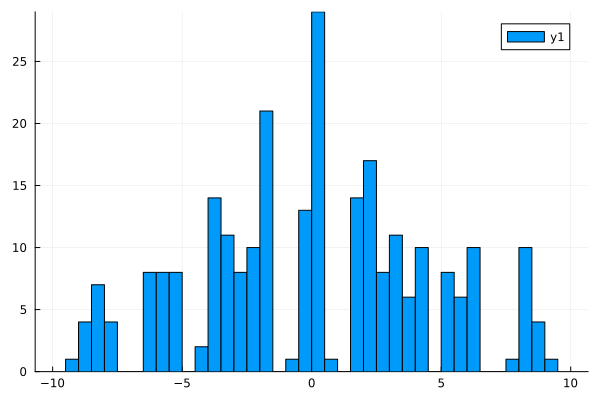

In [14]:
using Plots

histogram(E,nbins=50)

In [ ]:
using JLD2

jldsave(raw"D:\datasets\dqmc_hubbard\ED.jld2"; E=E, V=U,t=1, U=8,mu=2, half_filling=true, N_up=4, N_down=4, lattice=lattice)

In [4]:
using JLD2

d = load(raw"D:\datasets\dqmc_hubbard\ED.jld2")
V = d["V"]
lattice = d["lattice"]
t = d["t"]
E = d["E"]
μ = d["mu"]
N_up = d["N_up"]
N_down = d["N_down"]

4